# Taxi with SARSA

This exercise uses the SARSA algorithm to solve the taxi problem in OpenAI Gym.
SARSA is short for "state-action-reward-state-action" and is an on-policy algorithm where actions are chosen according to a specific policy.

We will use a table based approach for the Q-values
The overall algoritm is:
* Initialize $Q(s,a)$ 
* Obtain initial state $s$
* Repeat until terminal state is reached:
 * Choose action $a$ for state $s$ according a to specific policy (e.g. $\epsilon$-greedy)
 * Take action $a$ and observe reward $r$ and new state $s^\prime$.
 * Choose action $a^\prime$ for new state $s^\prime$ according to the same policy
 * Update $Q$ values $$Q(s,a) =  Q(s,a) + \alpha \left [r + \gamma Q(s^\prime,a^\prime)  - Q(s,a) \right ]  $$
 * set current state to new state: $s \leftarrow s^\prime$
 * set action to current action: $a \leftarrow a^\prime$.


In [37]:
# required imports

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

# clear the output of the cell to avoid long output lists
# see http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output
from IPython.display import clear_output

# for the animation at the end
from matplotlib import animation
from IPython.display import display
import time

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'gamma', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The environment consists of four points, the task is to pick up passengers at one point and deliver them to another.

More details about the environment are found [here](https://gym.openai.com/envs/Taxi-v3/)

In [38]:
# initialize the environment

env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [39]:
n_actions = env.action_space.n
n_states  = env.observation_space.n

# there are two ways to obtain the number of actions:
# env.nA and env.action_space.n
print('Number of actions: {} / {}'.format(env.nA, n_actions))
print('Action space: {}'.format(env.action_space))

# there are two ways to obtain the numbers of states: 
# env.nS and env.observation_space.n
print('Number of states: {} / {} '.format(env.nS, n_states))
print('State space: {}'.format(env.observation_space))

Number of actions: 6 / 6
Action space: Discrete(6)
Number of states: 500 / 500 
State space: Discrete(500)


## $\epsilon$-greedy Policy

define the $\epsilon$-greedy policy to choose an action



In [0]:
def policy(q_table, state, epsilon):
    randNo = random.uniform(0,1)
    if randNo < epsilon:
      action = env.action_space.sample() # choose random action
    else:
      action = np.argmax(q_table[state,:]) # choose current best action
    return action

## SARSA Algorithm

In [45]:
# greedy exploration probability
eps = 0.3

# learning rate
alpha = 0.3

#discount factor
gamma = 0.95

#number of episodes to train over:
n_episodes = 10000

#max number of steps in each episode
max_steps = 2500

# table of Q values
q_table = np.zeros([env.nS, env.nA])
#q_table = np.random.random((env.nS, env.nA))

# counter for how long each epoch lasted
epoch_list = []
reward_list = []

# loop over all episodes 
# (let the index run from 1 instead of 0 as we would count from 1)
for i in range(1, n_episodes+1):
  if i% 10 == 0:
    clear_output(wait=True)
    print('Now in episode {}'.format(i))

  # initialize each new episode
  s = env.reset()  # set the environment back to starting setting
                   # this returns the first observation, i.e. the 
                   # starting state environment is in.
  a = policy(q_table, s, eps) #obtain first action for this episode
                         
  epochs  = 0          # counter how long a given episode runs until it terminates
  rSum    = 0          # overall reward for this episode
  done    = False
  j       = 0

  # now interact with the environment until the episode ends
  # i.e. we either reach the goal or fall into a hole
  # protect against run-away processes and limit to 500 steps per episode
  while j < max_steps:
    j += 1
    epochs += 1

    #interact with environment
    s_prime, reward, done, info = env.step(a)
    rSum += reward

    #choose action for new state s_prime according to policy
    a_prime = policy(q_table, s_prime, eps)

    #update Q-table
    if done:
      q_table[s, a] += alpha*(reward - q_table[s, a])
    else:
      q_table[s, a] += alpha*(
          reward + (gamma*q_table[s_prime, a_prime] - q_table[s,a])
      )

    # set state, action to current values
    s = s_prime
    a = a_prime

    #check if episode ends
    if done:
      epoch_list.append(epochs)
      reward_list.append(rSum)
      break




Now in episode 10000


Now a distribution of how long each episode was

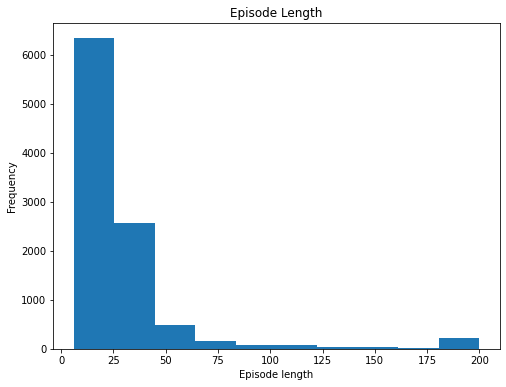

In [46]:
plt.hist(epoch_list)
plt.title('Episode Length')
plt.xlabel('Episode length')
plt.ylabel('Frequency')
plt.show()

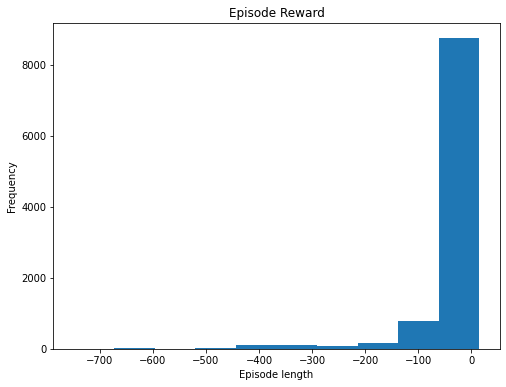

In [47]:
plt.hist(reward_list)
plt.title('Episode Reward')
plt.xlabel('Episode length')
plt.ylabel('Frequency')
plt.show()

This is the tabular list of Q-values to determine the best action.

In [48]:
print(q_table)

[[  0.           0.           0.           0.           0.
    0.        ]
 [-11.98464353  -9.39828913 -10.86552478 -10.94795935  -5.91024837
  -17.30265785]
 [ -4.59998644   0.50110888  -3.47039957  -1.53866593   2.77871991
  -10.59902127]
 ...
 [  0.09709084   6.78247791  -0.30852529   0.04817606 -11.54501045
   -7.72411362]
 [-11.06700961 -11.8003215  -10.58064136  -7.81618666 -17.9996234
  -16.39633039]
 [ 10.99077788  10.03431236   9.31175414  17.57370595   4.58465434
    4.79872049]]


Now a small animation testing the agent

In [59]:
frames = []
state  = env.reset()


for i in range(50):
  action = np.argmax(q_table[state,:])
  new_state, reward, done, info = env.step(action)
  env.render()
  print('Done? {}'.format(done))
  state = new_state



  frames.append({
      'frame'  : env.render(mode='ansi'),
      'state'  : state,
      'action' : action,
      'reward' : reward,
      'done'   : done
  })

  if done:
    break



#animation
for i, frame in enumerate(frames):
  clear_output(wait=True)
  print(frame['frame'])
  print(f"Timestep: {i}")
  print(f"State: {frame['state']}")
  print(f"Action: {frame['action']}")
  print(f"Reward: {frame['reward']}")
  print(f"Done: {frame['done']}")
  time.sleep(.2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 85
Action: 5
Reward: 20
Done: True
